# 2019 Data Science Bowl -- PBS Kids Measure Up


## Project Notebook

Team name:  Anonymous Chameleon

Team Members: Ariana Moncada, Hoda Noorian, Kevin Loftis

# Table of Contents

- [Imports](#Imports)
- [Data Cleaning](#Data-Cleaning)
- [Modeling](#Modeling)
- [Model Analysis](#Model-Analysis)
- [Submission](#Submission)

## Imports

In [1]:
%matplotlib inline
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import sklearn.linear_model as lm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import xgboost as xgb
from rfpimp import *
from sklearn.metrics import confusion_matrix

mpl.rcParams['figure.dpi'] = 150

In [2]:
path = Path('data/')

# Data Cleaning

## Read in data

In [3]:
print('Reading in train.csv')
train_data = pd.read_csv(path/'train.csv')
print('Reading in train_labels.csv')
train_labels = pd.read_csv(path/'train_labels.csv')
print('Reading in test.csv')
test_data = pd.read_csv(path/'test.csv')
print('Reading in specs.csv')
specs = pd.read_csv(path/'specs.csv')

Reading in train.csv
Reading in train_labels.csv
Reading in test.csv
Reading in specs.csv


In [4]:
event_description_dict = {row.event_id:row.info for idx,row in specs.iterrows()}

In [5]:
unique_titles = set(train_data.title.unique()).union(set(test_data.title.unique()))

In [6]:
# reduces data with respect to each installation id
def reduce_data_per_user(user_dataframe):
    '''
    Helper function to aggregate data.  To be used inside the function to_reduce.
    This function expects as input a dataframe with all rows pertaining to a given
    installation id.  The data frame is then grouped by game session and features are
    aggregated.  Features include total number events, number of events types, game session
    length, etc.  
    
    If the game session is an 'Assessment' session then the current counts are recorded as a row
    in the aggregated dataset.  Since the game session ids in the labels only correspond to the
    Assessment session, we only want to record accumulated features just before the assessment.  This
    gives an estimate of the state of the user just before they take an assessment which we then use
    for prediction.
    '''
    event_counts = {'total_events':0,
                    'clips_count':0,
                    'assessment_count':0,
                    'activity_count':0,
                    'game_count':0,
                    'correct_events_count':0,
                    'incorrect_events_count':0
                   }
    
    specific_event_counts = dict(zip(specs.event_id,[0 for _ in range(specs.shape[0])]))
    unique_titles_counts = dict(zip(unique_titles,[0 for _ in range(len(unique_titles))]))
    median_session_times = []
    df_features = []
    for idx,session in user_dataframe.groupby('game_session',sort=False):
        if session.type.iloc[0]=='Assessment':
            assessment_info = {'assess_world':session.world.iloc[0],
                               'assess_title':session.title.iloc[0],
                               'game_session':session.game_session.iloc[0],
                               'installation_id':session.installation_id.iloc[0]
                              }
            
            df_features.append({**event_counts,**assessment_info,**specific_event_counts,
                                'median_session_time':np.median(median_session_times),
                                **unique_titles_counts})
            event_counts['assessment_count'] += (session.type == 'Assessment').sum()
            unique_titles_counts[session.iloc[0].title]+=1
        else:
            event_counts['total_events'] += session.event_id.count()
            event_counts['clips_count'] += (session.type == 'Clip').sum()
            event_counts['activity_count'] += (session.type == 'Activity').sum()
            event_counts['game_count'] += (session.type == 'Game').sum()
            event_counts['correct_events_count'] += (session.event_id
                                                     .map(event_description_dict)
                                                     .str.contains('Correct').sum())
            event_counts['incorrect_events_count'] += (session.event_id
                                                       .map(event_description_dict)
                                                       .str.contains('Incorrect').sum())
            specific_event_counts.update(dict(session.event_id.value_counts()))
            unique_titles_counts[session.iloc[0].title]+=1
            median_session_times.append(session.game_time.max())
    return df_features

In [7]:
def reduce_data(valid_install_ids,data,is_train_data=True):
    '''
    Main function that aggregates the data.
    
    Takes install_ids that are used for aggregating (note that there are some installation
    ids that do not have a row in the labels) and aggregates.  If is_train_data is True, then
    the aggregated table is merged with the labels, otherwise just the aggregated table is returned.
    '''
    rows = []
    for install_id,df in tqdm(data.groupby('installation_id')):
        if install_id in valid_install_ids: # only aggregate if install_id exists in train_labels
            rows.extend(reduce_data_per_user(df))
        else:
            continue
    data = pd.DataFrame(rows)
    if is_train_data:
        return train_labels[['game_session','accuracy_group']]\
                        .merge(data,on='game_session',how='inner')\
                        .drop(['game_session'],axis=1)
    else:
        return data.groupby('installation_id',as_index=False).apply(lambda x: x.iloc[-1]).drop(['game_session'],axis=1)

In [8]:
def get_cols_with_constant_values(data):
    '''
    Given the aggregated dataset, returns the indicies of the
    columns with a constant value.
    '''
    drop_cols = []
    for i in range(data.shape[1]):
        if data.iloc[:,i].nunique() == 1:
            drop_cols.append(data.columns[i])
    return drop_cols

In [9]:
use_cached_table = True # set to False if you want to recompute
train_agg_path = path/'train_reduced.csv'
test_agg_path = path/'test_reduced.csv'
if use_cached_table:
    train_reduced = pd.read_csv(train_agg_path,index_col=0)
    test_reduced = pd.read_csv(test_agg_path,index_col=0)
else:
    train_reduced = reduce_data(train_labels.installation_id.unique(),train_data)
    test_reduced = reduce_data(test_data.installation_id.unique(),test_data, is_train_data = False)
    drop_cols = get_cols_with_constant_values(train_reduced) # get columns with constant values
    train_reduced = train_reduced.drop(drop_cols,axis=1) # drop columns from train set with constant vals
    test_reduced = test_reduced.drop(drop_cols,axis=1)   # drop columns from test set with constant vals

In [10]:
# save tables
train_reduced.to_csv(path/'train_reduced.csv')
test_reduced.to_csv(path/'test_reduced.csv')

# Modeling

In [11]:
worlds = list(set(train_reduced.assess_world.unique()).union(test_reduced.assess_world.unique()))
titles = list(set(train_reduced.assess_title.unique()).union(test_reduced.assess_title.unique()))

Split the data into a training set and hold out set.  All validation and hyperparameter tuning will be done on the training set and at the very end will test model on the hold out set.

In [12]:
X_col_names = [col for col in train_reduced.columns if col not in ['accuracy_group','installation_id',
                                                                   'median_session_time']]
X = train_reduced.loc[:,X_col_names]
y = train_reduced.loc[:,'accuracy_group']
train_x,test_x, train_y,test_y = train_test_split(X,y,test_size=.1)

Before moving forward with the model fitting lets examine the distibution of accuracy groups in the train set

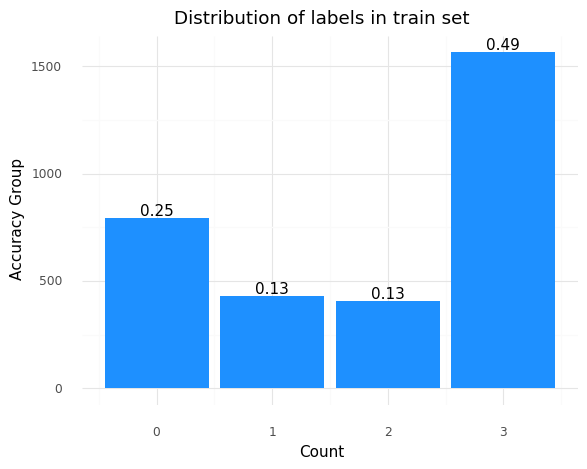

In [13]:
plot = ggplot(data=pd.DataFrame(train_y))\
        + geom_bar(aes(x='accuracy_group'),fill='dodgerblue')\
        + ggtitle('Distribution of labels in train set')\
        + geom_text(aes(x='accuracy_group',label='round(..prop..,2)'), stat='count',vjust='bottom')\
        + xlab('Count')\
        + ylab('Accuracy Group')\
        + theme_minimal()
plot.draw();

About half of the observations fall into group 3.  To balance this we chose balance out the classes using SMOTENC.

In [14]:
smote = SMOTENC([7,8])
train_x_smote,train_y_smote = smote.fit_resample(train_x,train_y)
train_x_smote = pd.DataFrame(train_x_smote,columns=X_col_names)

train_x_smote['installation_id'] = 1
train_x['installation_id'] = 1 

/Users/loftis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/loftis/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/loftis/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./before_after_smote.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


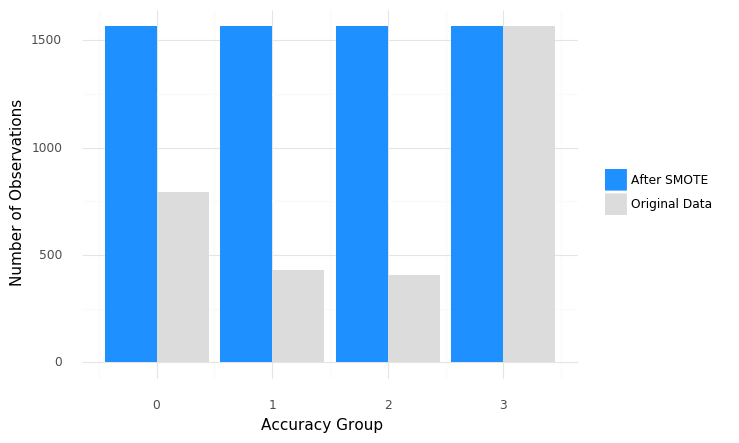

In [15]:
def plot_before_after_smote_y_dist():
    '''
    ggplot code to plot distribution of labels before and after SMOTENC resampling
    '''
    df1, df2 = (pd.DataFrame({'accuracy_group':train_y}),
                pd.DataFrame({'accuracy_group':train_y_smote}))
    df1['smote'] = 'Original Data'
    df2['smote'] = 'After SMOTE'
    df = pd.concat([df1,df2],axis=0)
    plot = (ggplot(data=df)+
            geom_bar(aes(x='accuracy_group',fill='smote'),position=position_dodge())+
            xlab('Accuracy Group')+
            ylab('Number of Observations')+
            theme_minimal()+
            theme(legend_title = element_blank())+
            scale_fill_manual(['dodgerblue','gainsboro']))
    return plot
plot = plot_before_after_smote_y_dist()
plot.save(filename='./before_after_smote.png',dpi=400)
plot.draw();

After SMOTENC resampling, the classes are balanced.  We will fit both the SMOTENC sampled data and on non-smote samples.

In [16]:
def evaluate_model(model,x,y,n_jobs=4):
    '''
    helper function to evaluate models.  Compute the 5 fold cross validation and prints 
    report of averge CV fold and training set scores for the following metrics:
        quadratic_cappa
        weighted_f1
        accuracy
    '''
    scorers = {'quadratic_cappa':make_scorer(cohen_kappa_score,weights='quadratic'),
               'weighted_f1':make_scorer(metrics.f1_score,average='weighted'),
               'accuracy':make_scorer(metrics.accuracy_score)}

    CV = cross_validate(model,x,y,cv=5,n_jobs=n_jobs,scoring=scorers,return_train_score=True)
    
    train_cv_quadrtic_cappa_mean = CV['train_quadratic_cappa'].mean()
    train_cv_quadrtic_cappa_std = CV['train_quadratic_cappa'].std()
    test_cv_quadrtic_cappa_mean = CV['test_quadratic_cappa'].mean()
    test_cv_quadrtic_cappa_std = CV['test_quadratic_cappa'].std()
    
    train_cv_weighted_f1_mean = CV['train_weighted_f1'].mean()
    train_cv_weighted_f1_std = CV['train_weighted_f1'].std()
    test_cv_weighted_f1_mean = CV['test_weighted_f1'].mean()
    test_cv_weighted_f1_std = CV['test_weighted_f1'].std()
    
    train_cv_accuracy_mean = CV['train_accuracy'].mean()
    train_cv_accuracy_std = CV['train_accuracy'].std()
    test_cv_accuracy_mean = CV['test_accuracy'].mean()
    test_cv_accuracy_std = CV['test_accuracy'].std()
    
    print(f'Quadratic Kappa mean Train: {train_cv_quadrtic_cappa_mean:.3f} std: {train_cv_quadrtic_cappa_std:.3f}')
    print(f'Quadratic Kappa mean CV: {test_cv_quadrtic_cappa_mean:.3f} std: {test_cv_quadrtic_cappa_std:.3f}')
    print()
    print(f'Weighted F1 mean Train: {train_cv_weighted_f1_mean:.3f} std: {train_cv_weighted_f1_std:.3f}')
    print(f'Weighted F1 mean CV: {test_cv_weighted_f1_mean:.3f} std: {test_cv_weighted_f1_std:.3f}')
    print()
    print(f'Accuracy mean Train: {train_cv_accuracy_mean:.3f} std: {train_cv_accuracy_std:.3f}')
    print(f'Accuracy mean CV: {test_cv_accuracy_mean:.3f} std: {test_cv_accuracy_std:.3f}')

In [17]:
preprocessor = ColumnTransformer([('onehot1',OneHotEncoder(),['assess_world']),
                                  ('onehot2',OneHotEncoder(),['assess_title']),
                                  ('drop', 'drop',['installation_id'])],
                                  remainder='passthrough')

Start with a baseline model of Lasso Logistic Regression. Try lasso logistic regression for both SMOTENC resampled data and non-resampled data

In [20]:
print(f'Lasso Logistic Regression results')
lasso_pipe = Pipeline([('col_transform',preprocessor),
                         ('cls',OneVsRestClassifier(lm.Lasso(normalize=True,max_iter=5000,alpha=2e-5)))])
evaluate_model(lasso_pipe,train_x,train_y.to_numpy())

Lasso Logistic Regression results
Quadratic Kappa mean Train: 0.585 std: 0.007
Quadratic Kappa mean CV: 0.528 std: 0.031

Weighted F1 mean Train: 0.591 std: 0.003
Weighted F1 mean CV: 0.549 std: 0.011

Accuracy mean Train: 0.653 std: 0.003
Accuracy mean CV: 0.613 std: 0.012


In [21]:
lasso_pipe.fit(train_x,train_y);

In [22]:
print(f'Lasso Smote Regression results')
lasso_smote_pipe = Pipeline([('col_transform',preprocessor),
                         ('cls',OneVsRestClassifier(lm.Lasso(normalize=True,max_iter=5000,alpha=2e-5)))])
evaluate_model(lasso_smote_pipe,train_x_smote,train_y_smote,n_jobs=1)

Lasso Smote Regression results
Quadratic Kappa mean Train: 0.592 std: 0.018
Quadratic Kappa mean CV: 0.558 std: 0.050

Weighted F1 mean Train: 0.588 std: 0.011
Weighted F1 mean CV: 0.551 std: 0.028

Accuracy mean Train: 0.591 std: 0.011
Accuracy mean CV: 0.555 std: 0.029


Note that the smote dataset actually performed worse for the lasso model.

In [23]:
lasso_smote_pipe.fit(train_x_smote,train_y_smote);

In [24]:
rf_pipe = Pipeline([('col_transform',preprocessor),
                 ('cls',RandomForestClassifier(n_estimators=250,
                                               max_features = int(np.sqrt(train_x.shape[1])),
                                               min_samples_leaf=10))])

In [25]:
print(f'Random Forest results')
evaluate_model(rf_pipe,train_x,train_y,n_jobs=1)

Random Forest results


/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Quadratic Kappa mean Train: 0.611 std: 0.012
Quadratic Kappa mean CV: 0.439 std: 0.022

Weighted F1 mean Train: 0.607 std: 0.007
Weighted F1 mean CV: 0.511 std: 0.010

Accuracy mean Train: 0.678 std: 0.005
Accuracy mean CV: 0.597 std: 0.010


In [26]:
rf_pipe.fit(train_x,train_y);

In [27]:
print(f'Random Forest SMOTE results')
rf_smote_pipe = Pipeline([('col_transform',preprocessor),
                 ('cls',RandomForestClassifier(n_estimators=250,
                                               max_features = int(np.sqrt(train_x.shape[1])),
                                               min_samples_leaf=10))])
evaluate_model(rf_smote_pipe,train_x_smote,train_y_smote,n_jobs=1)

Random Forest SMOTE results
Quadratic Kappa mean Train: 0.784 std: 0.027
Quadratic Kappa mean CV: 0.626 std: 0.135

Weighted F1 mean Train: 0.846 std: 0.024
Weighted F1 mean CV: 0.689 std: 0.116

Accuracy mean Train: 0.846 std: 0.024
Accuracy mean CV: 0.692 std: 0.108


SMOTENC resampling help the Random Forest (RF) Model acheive a higher mean CV score, however the standard deviation of the scoring metrics are much higher than that of the RF model trained on the regular data.

In [28]:
rf_smote_pipe.fit(train_x_smote,train_y_smote);

In [29]:
gb_pipe = Pipeline([('col_transform',preprocessor),
                    ('cls',xgb.XGBClassifier(learning_rate=.01))])

In [30]:
print('XGBoost Classifier Results')
evaluate_model(gb_pipe,train_x,train_y,n_jobs=1)

XGBoost Classifier Results


/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Quadratic Kappa mean Train: 0.528 std: 0.006
Quadratic Kappa mean CV: 0.482 std: 0.016

Weighted F1 mean Train: 0.575 std: 0.002
Weighted F1 mean CV: 0.535 std: 0.010

Accuracy mean Train: 0.629 std: 0.003
Accuracy mean CV: 0.592 std: 0.013


In [31]:
gb_pipe.fit(train_x,train_y);

In [32]:
gb_smote_pipe = Pipeline([('col_transform',preprocessor),
                    ('cls',xgb.XGBClassifier(learning_rate=.01))])
print('XGBoost Classifier SMOTE Results')
evaluate_model(gb_pipe,train_x_smote,train_y_smote,n_jobs=1)

XGBoost Classifier SMOTE Results
Quadratic Kappa mean Train: 0.546 std: 0.027
Quadratic Kappa mean CV: 0.531 std: 0.084

Weighted F1 mean Train: 0.553 std: 0.028
Weighted F1 mean CV: 0.524 std: 0.070

Accuracy mean Train: 0.564 std: 0.025
Accuracy mean CV: 0.540 std: 0.062


In [33]:
gb_smote_pipe.fit(train_x_smote,train_y_smote);

The XGBoost did not perform as well as the RF model.

In [34]:
models = {'Lasso':lasso_pipe,'Lasso w/ SMOTE':lasso_smote_pipe,
          'Random Forest':rf_pipe, 'Random Forest w/ SMOTE':rf_smote_pipe,
          'XGBoost':gb_pipe, 'XGBoost w/ SMOTE':gb_smote_pipe}

In [35]:
def evaluate_models(models):
    """
    Evaluates models on the testing holdout set to get a true measure of performance to
    compare with the other models.
    """
    for model_name,model in models.items():
        predictions = model.predict(test_x)
        kappa = cohen_kappa_score(predictions,test_y,weights='quadratic')
        f1 = metrics.f1_score(predictions,test_y,average='weighted')
        acc = metrics.accuracy_score(predictions,test_y)
        print(f'{model_name} Results')
        print(f'Quadratic Kappa: {kappa}')
        print(f'Weighted F1 score: {f1}')
        print(f'Accuracy F1 score: {acc}')
        print()
        

In [36]:
evaluate_models(models)

Lasso Results
Quadratic Kappa: 0.5077665333019534
Weighted F1 score: 0.6571931787809396
Accuracy F1 score: 0.5926966292134831

Lasso w/ SMOTE Results
Quadratic Kappa: 0.501862310479545
Weighted F1 score: 0.46814019483653063
Accuracy F1 score: 0.4887640449438202

Random Forest Results
Quadratic Kappa: 0.4794407894736842
Weighted F1 score: 0.6832762173098774
Accuracy F1 score: 0.601123595505618

Random Forest w/ SMOTE Results
Quadratic Kappa: 0.5159359437554927
Weighted F1 score: 0.5888865701932527
Accuracy F1 score: 0.5702247191011236

XGBoost Results
Quadratic Kappa: 0.497588789288551
Weighted F1 score: 0.639400110570868
Accuracy F1 score: 0.5786516853932584

XGBoost w/ SMOTE Results
Quadratic Kappa: 0.4627263793345501
Weighted F1 score: 0.5468839856299715
Accuracy F1 score: 0.5252808988764045



/Users/loftis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The random forest model trained on the SMOTENC resample performed the best measured by the quadratic kappa.  For this point forward I will analyze the outputs of this model

## Model Analysis

In [37]:
# get predictions of winning model for model analysis
predictions = rf_smote_pipe.predict(test_x) 

Lets first take a look at the confusion matrix of the predictions on our hold out set of the RF model trained on SMOTENC resampled data

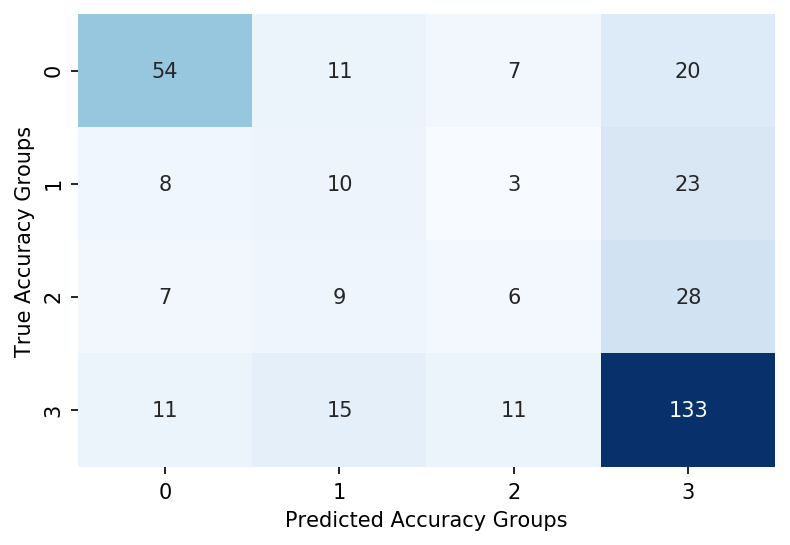

In [38]:
sns.heatmap(confusion_matrix(test_y,predictions),annot=True,
            cmap='Blues',fmt='d',cbar=False)
plt.ylabel('True Accuracy Groups')
plt.xlabel('Predicted Accuracy Groups');

The model performs better on individual that are part of accuacy group 0 (assessment never solved) and group 3 (assessment solve on first try).  However, the model has a hard time with groups 1(assessment solved in 3+ tries) and 2(assessment solved in 2 tries).

The confusion matrix suggests that individuals of group 2 look extremely similar to those in group 3 with the majority of the true group 2 individuals predicted to be part of group 3. Users who get it in one try vs two tries are probably very similar.

The model similarly had difficult predicting individuals in accuaracy group 1, bucketing the majority of true group ones in either group 0 or 3.  Interestingly, the model did not mispredict into 2 as often as one might think given that they are adjacent classes.

Next lets examine which features are important to the model using permutation feature importance.

In [39]:
imps = importances(rf_smote_pipe,train_x,train_y)

In [40]:
top_20_imps = imps[:20].reset_index()
top_20_imps['Feature'] = pd.Categorical(top_20_imps['Feature'],categories=top_20_imps['Feature'])

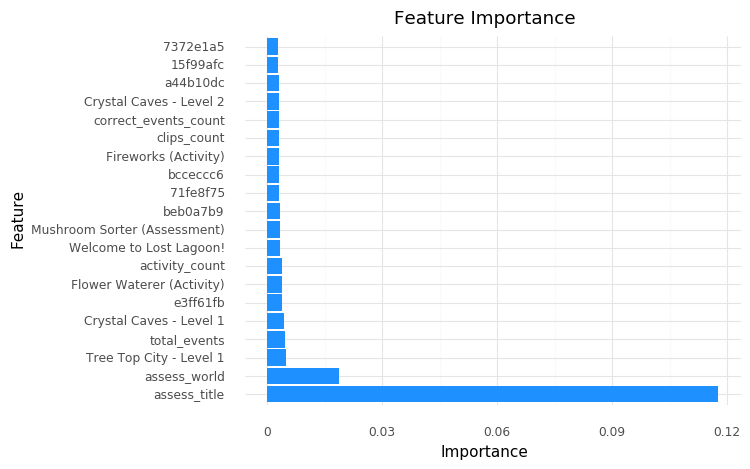

In [41]:
plot = ggplot(data = top_20_imps) +\
            geom_bar(aes(x='Feature',y='Importance'),
                     stat='identity',fill='dodgerblue')+\
            coord_flip()+\
            theme_minimal() +\
            labs(title='Feature Importance')
plot.draw();

The most important feature according to the feature importance above is the assess_title feature.  This feature indicates which assessment the user is taking.  For some assessments individual probably do worse on average making this a string feature.

In addition to assess title there are a few features with strange strings like b012cd7f.  These correspond the the number of a that events triggered prior to the start.  Let's take a look at a couple of the top event descriptions.

In [42]:
list(specs.loc[specs.event_id == 'b012cd7f','info'])

['The beat round event is triggered when the player finishes a round. This event is used for calculating time spent in a round (for speed and accuracy) attempts at solving a round and the number of rounds the player has completed (completion).']

The above event description triggers when the user beats a round.  This make sense.  The more rounds beaten (or not beaten) seem like it would be a pretty good indicator or mastery of a skill that would probably be predictive of future performance on an assessment

In [43]:
list(specs.loc[specs.event_id == 'e5734469','info'])

['The system-initiated feedback (Incorrect) event occurs when the game starts delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like "did players who received feedback X do better than those who did not?"']

In [44]:
list(specs.loc[specs.event_id == '58a0de5c','info'])

['The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, how much time elapsed while the game was presenting feedback?""']

The above two events above are interesting in that they are triggered when feedback (either correct or incorrect) is delivered.  Again similar to the 'beat round' event, the more correct or incorrect feedback given to a user would probably be indicative of their performance on future assessments.